# Goal: Calculate $A_{sym}$ for different energy thresholds or energy bins

This is a very simple and straightforward way of demonstrating that higher energy neutrons experience stronger anisotropy. 

We will calculate the magnitude of anisotropy as a one-dimensional parameter as:

$$A_{sym} = \frac{W(180^\circ)}{W(90^\circ)}$$

This is the same method as Tony Shin is using in his multiplicity counter work, and the same method that several previous papers have used. 

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import imageio

In [2]:
import pandas as pd

In [3]:
import seaborn as sns
sns.set(style='ticks')

In [4]:
sys.path.append('../scripts/')

In [5]:
import bicorr as bicorr
import bicorr_plot as bicorr_plot
import bicorr_sums as bicorr_sums
import bicorr_math as bicorr_math

In [6]:
%load_ext autoreload
%autoreload 2

# Load the data

According to the method I laid out at the end of `singles_correction.ipynb`, I need to load the following data:

* det_df
* dict_index_to_det
* singles_hist
* dt_bin_edges_sh
* bhp_nn_pos
* bhp_nn_neg
* dt_bin_edges
* emin
* emax
* num_fissions
* angle_bin_edges

I will work with the data from the combined data sets in `analysis\Cf072115_to_Cf072215b`.

In [7]:
det_df = bicorr.load_det_df('../meas_info/det_df_pairs_angles.csv', remove_fc_neighbors = True)

In [8]:
singles_hist, dt_bin_edges_sh, dict_det_to_index, dict_index_to_det = bicorr.load_singles_hist(filepath='../analysis/Cf072115_to_Cf072215b/datap')

In [9]:
npzfile = np.load('../analysis/Cf072115_to_Cf072215b/datap/bhp_nn_by_pair_1ns.npz')
bhp_nn_pos = npzfile['bhp_nn_pos']
bhp_nn_neg = npzfile['bhp_nn_neg']
dt_bin_edges = npzfile['dt_bin_edges']

`emin`, `emax` will be input parameters. I will vary `emin`.

In [10]:
num_fissions = 2194651200.00
angle_bin_edges = np.arange(8,190,10)

# Calculate $A_{sym}$ in a given energy range

Use the all-in-one function for calculating `singles_df`, `det_df`, and `by_angles_df` in one step: `bicorr_sums.perform_W_calcs`.
Look at what has been our default energy range.

## Produce all of the relevant dataframes

In [22]:
emin = .62
emax = 12

The code will produce the sum across energy ranges that are rounded down from these values to find the bin edges. Where should I get them back from?

Add optional flag to return `energies_real`. This way it won't break all my old notebooks. Note that energies_real is `[emax_real,emin_real]`.

In [23]:
singles_df, det_df, by_angle_df, energies_real = bicorr_sums.perform_W_calcs(det_df,
                    dict_index_to_det, singles_hist, dt_bin_edges_sh,
                    bhp_nn_pos, bhp_nn_neg, dt_bin_edges,
                    num_fissions, emin, emax, angle_bin_edges, return_real_energies_flag = True)
print(energies_real)

[11.915598705935022, 0.60755914317462678]


## Store information at $180^\circ$ and $90^\circ$

Find the bins in `by_angle_df` that contain $180^\circ$ and $90^\circ$.

In [24]:
angle_bin_edges

array([  8,  18,  28,  38,  48,  58,  68,  78,  88,  98, 108, 118, 128,
       138, 148, 158, 168, 178, 188])

In [25]:
series_180 = by_angle_df.loc[np.int(np.digitize(180,angle_bin_edges))-1]

In [26]:
series_90 = by_angle_df.loc[np.int(np.digitize(90,angle_bin_edges))-1]

In [27]:
series_180['W']/series_90['W']

1.5249435107256457

In [28]:
num = series_180['W']
num_err = series_180['W_err']
denom = series_90['W']
denom_err = series_90['W_err']

Asym, Asym_err = bicorr_math.prop_err_division(num,num_err,denom,denom_err)

In [29]:
Asym

1.5249435107256457

## Functionalize this

In [30]:
bicorr_sums.calc_Asym(by_angle_df)

(1.5249435107256457, 0.033908127615987806)

# Calculate for variable `emin`

## Create `Asym_df` for storing results

Create a dataframe for storing these values, because I like dataframes now. 

In [31]:
emins = np.arange(0.5,5,.2)
print(emins)
emax = 12

[ 0.5  0.7  0.9  1.1  1.3  1.5  1.7  1.9  2.1  2.3  2.5  2.7  2.9  3.1  3.3
  3.5  3.7  3.9  4.1  4.3  4.5  4.7  4.9]


In [49]:
Asym_df = pd.DataFrame(data = emins, columns = {'emin'})
Asym_df['emax'] = emax
Asym_df['Asym'] = np.nan
Asym_df['Asym_err'] = np.nan

In [50]:
Asym_df.head()

,emin,emax,Asym,Asym_err
0,0.5,12,NaN,NaN
1,0.7,12,NaN,NaN
2,0.9,12,NaN,NaN
3,1.1,12,NaN,NaN
4,1.3,12,NaN,NaN


## Fill `Asym_df`

In [69]:
for index, row in Asym_df.iterrows():    
    singles_df, det_df, by_angle_df = bicorr_sums.perform_W_calcs(det_df,
                    dict_index_to_det, singles_hist, dt_bin_edges_sh,
                    bhp_nn_pos, bhp_nn_neg, dt_bin_edges,
                    num_fissions, row['emin'], row['emax'], angle_bin_edges)
    Asym, Asym_err = bicorr_sums.calc_Asym(by_angle_df)
    
    Asym_df.loc[index,'Asym'] = Asym
    Asym_df.loc[index,'Asym_err'] = Asym_err

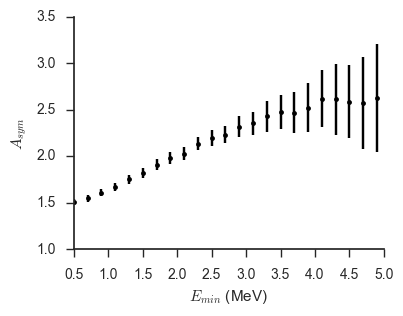

In [66]:
plt.figure(figsize=(4,3))
plt.errorbar(Asym_df['emin'],Asym_df['Asym'],yerr=Asym_df['Asym_err'],fmt='.',color='k')
plt.xlabel('$E_{min}$ (MeV)')
plt.ylabel('$A_{sym}$')
plt.title('Errors from std(W)')
sns.despine(right=True)
bicorr_plot.save_fig_to_folder('Asym_vs_angle_std_W')
plt.show()

If instead I want to propagate errors from `W_err` (statistical error):

In [67]:
for index, row in Asym_df.iterrows():    
    singles_df, det_df, by_angle_df = bicorr_sums.perform_W_calcs(det_df,
                    dict_index_to_det, singles_hist, dt_bin_edges_sh,
                    bhp_nn_pos, bhp_nn_neg, dt_bin_edges,
                    num_fissions, row['emin'], row['emax'], angle_bin_edges)
    Asym, Asym_err = bicorr_sums.calc_Asym(by_angle_df, std_flag=False)
    
    Asym_df.loc[index,'Asym'] = Asym
    Asym_df.loc[index,'Asym_err'] = Asym_err

## Plot, save figure

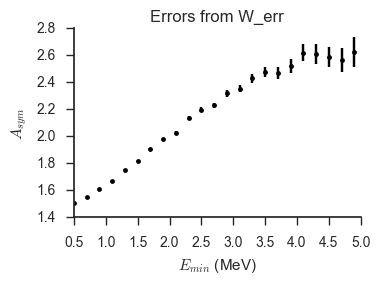

In [68]:
plt.figure(figsize=(4,3))
plt.errorbar(Asym_df['emin'],Asym_df['Asym'],yerr=Asym_df['Asym_err'],fmt='.',color='k')
plt.xlabel('$E_{min}$ (MeV)')
plt.ylabel('$A_{sym}$')
plt.title('Errors from W_err')
sns.despine(right=True)
bicorr_plot.save_fig_to_folder('Asym_vs_angle_W_err')
plt.show()

## Functionalize this

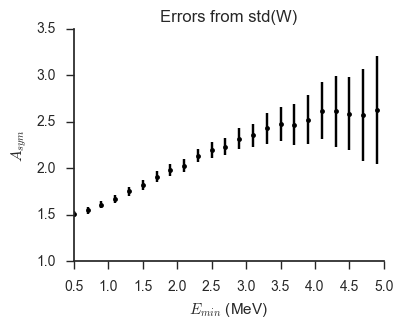

,emin,emax,Asym,Asym_err
0,0.5,12,1.502363,0.033244
1,0.7,12,1.545859,0.035890
2,0.9,12,1.604191,0.038897
3,1.1,12,1.668908,0.042293
4,1.3,12,1.749523,0.046560


In [72]:
Asym_df = bicorr_sums.calc_Asym_vs_emin(det_df,
                    dict_index_to_det, singles_hist, dt_bin_edges_sh,
                    bhp_nn_pos, bhp_nn_neg, dt_bin_edges,
                    num_fissions, emins, emax, angle_bin_edges,
                    plot_flag=True, save_flag=False)
Asym_df.head()

I'm updating this to return `emin_real` and `emax_real`, which are slightly different than `emin` and `emax` due to discrete binning. 

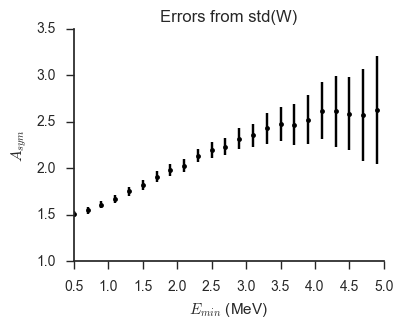

,emin,emax,emin_real,emax_real,Asym,Asym_err
0,0.5,12,0.495313,11.915599,1.502363,0.033244
1,0.7,12,0.694250,11.915599,1.545859,0.035890
2,0.9,12,0.886284,11.915599,1.604191,0.038897
3,1.1,12,1.072404,11.915599,1.668908,0.042293
4,1.3,12,1.282905,11.915599,1.749523,0.046560


In [32]:
Asym_df = bicorr_sums.calc_Asym_vs_emin(det_df,
                    dict_index_to_det, singles_hist, dt_bin_edges_sh,
                    bhp_nn_pos, bhp_nn_neg, dt_bin_edges,
                    num_fissions, emins, emax, angle_bin_edges,
                    plot_flag=True, save_flag=False)
Asym_df.head()

# Calculate for variable `ebin`

Instead of varying energy threshold, only select events within a given energy bin, bound by emin, emax.

The only thing I really need to change is how I initialize `Asym_df`.

In [13]:
e_bin_edges = np.arange(0.5,5,.2)

In [17]:
Asym_df = pd.DataFrame(data = {'emin':e_bin_edges[:-1],'emax':e_bin_edges[1:]})
Asym_df.head()

,emax,emin
0,0.7,0.5
1,0.9,0.7
2,1.1,0.9
3,1.3,1.1
4,1.5,1.3


I updated this method in a new function called `bicorr_sums.calc_Asym_vs_ebin`. The rest of the function is the same as `calc_Asym_vs_emin`.

../scripts\bicorr_math.py:28: RuntimeWarning: invalid value encountered in double_scalars
  A = num/denom
../scripts\bicorr_math.py:30: RuntimeWarning: invalid value encountered in double_scalars
  A_err = A*np.sqrt((num_err/num)**2+(denom_err/denom)**2)


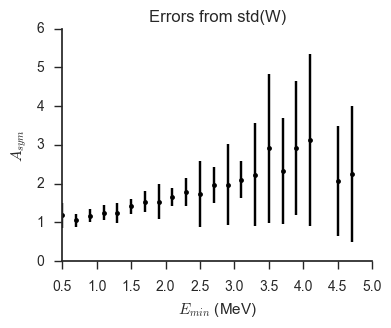

,emax,emin,Asym,Asym_err
0,0.7,0.5,1.174629,0.331594
1,0.9,0.7,1.050754,0.167779
2,1.1,0.9,1.172604,0.167299
3,1.3,1.1,1.243500,0.190377
4,1.5,1.3,1.243286,0.257328


In [20]:
Asym_df = bicorr_sums.calc_Asym_vs_ebin(det_df,
                    dict_index_to_det, singles_hist, dt_bin_edges_sh,
                    bhp_nn_pos, bhp_nn_neg, dt_bin_edges,
                    num_fissions, e_bin_edges, angle_bin_edges,
                    plot_flag=True, save_flag=False)
Asym_df.head()